Below is a concise, example-driven tutorial that illustrates how to use your toolbox to simulate MEG/EEG data with known “ground truth” effects, then test whether a decoding analysis can successfully detect those effects. This guides new users through the typical workflow: defining an experimental design, specifying when each effect should be present in time, generating data, and finally verifying that a chosen analysis pipeline can uncover the artificially injected effects.

## Motivation and Overview
One critical challenge in designing analysis pipelines for MEG/EEG data is confirming that the pipeline is both sensitive (i.e., it detects real effects) and specific (i.e., it avoids false alarms). In most cases, it is not known a priori whether or when experimental effects are present in the data, and it is therefore not possible to assess the sensitivity and specificity of analysis pipelines based on the data one is trying to analyse. 

This toolbox offers a solution to this issue, by allowing users to simulate MEG/EEG data that mimicks the data set that they plan to or have already collected (number of participants, experimental design...), enabling to test that the designed pipelines are capable of detecting the effects of interest.

Specifically, the toolbox allows to:
- Specify a between-trial design (e.g., two conditions, Condition A and Condition B).
- Inject multivariate effects at particular time windows (e.g., Condition A is active from 100–200 ms, Condition B from 300–400 ms).
- Generate a realistic dataset (with noise, trial variability, and optionally correlated sensor modes).
- Analyze that dataset (e.g., classification, sensor-level univariate tests, source localization, etc.).
- Validate that the pipeline recovers the known effects accurately.

Below, we walk through a minimal but representative example.

## 1. Defining an Experimental Design

Imagine we have a simple 2x2 experimental design, in which we presented trials of 2 different categories (say faces and objects) in two different attention condition (attended vs. unattended condition). In each attention condition, we have presented 40 faces and 40 objects, resulting in a total of 160 trials in total. We will specify a design matrix of 160 rows (1 per trial) and with 2 columns: 

| Category    | Attention |
| -------- | ------- |
| face | attended    |
| face | unattended     |
| object| attended    |
| object| unattended    |
| ...| ...    |

We will create this design matrix, encoding as 1 and -1 each condition (face: 1, object: -1, attended: 1, unattended: -1)

In [1]:
import numpy as np

# Creating the design matrix of our 2 by two balanced design:
X = np.array([[1, 1, -1, -1] * 40, [1, -1] * 80]).T

# Add descriptors:
cond_names = ["category", "attention"]
mapping = {
    "category": {1: "face", -1: "object"},
    "attention": {1: "attended", -1: "unattended"}
}

## 3. Specifying Time Windows for the Effects

Now let's imagine that in our design, each stimulus was presented for 0.25s followed by a blank screen for 0.75s, such that each trial lasted 1 sec. And in addition, we have a baseline time window of 0.25s before each stimulus. 

For each condition we want to inject an effect (i.e., a multivariate pattern representing the content of interest) at a specific time. Let’s say:
- Faces vs. objects is active from 100 ms to 200 ms
- Attended vs. unattended is active from 300 ms to 400 ms

To simulate data accordingly, we need to specify the index for which we want to inject an effect (in our case for the first and the second column of our design matrix), and for each, we need to specify the time window in which we want the effect to be present, like so:

In [2]:
# The 'effects' array tells us which columns in X are 'active' at each time window.
# Here we say effect 0 => category, effect 1 => attention
effects = np.array([0, 1])

# For each effects, define a 2x2 array where each row is [start_ms, end_ms]
t_win = np.array(
    [
        [0.100, 0.200],  # Condition 0 active window
        [0.300, 0.400],  # Condition 1 active window
    ]
)

You may be wondering: what about interactions? You might very well expect that there is an interaction between category and attention: faces vs. objects can only be decoded in the attended and not in the attended condition. We need to extend our design matrix X to include such an interaction:

In [3]:
interaction = X[:, 0] * X[:, 1]
X = np.column_stack(
    [X, interaction]
)  # Add a column for the interaction between category and attention

So if you want to inject an interaction effect at a particular time point, you simply need to add one more effect (i.e. the third column) at the time point of your choice. To keep things simple here, we will keep the interaction to 0.

## 4. Simulating the Data

So far, we have created our design matrix X, we know that a trial lasts from -0.250 to 1.0s from stimulus onset (i.e. 250ms baseline and 1s after stimulus onset), and we have specified when and what effects we want to have. We need to specify a few more things regarding our data:
- n_channels: the number of channels of the MEG/EEG recordings we plan to analyze
- sfreq: the sampling frequency of our signal
- n_subjects: the number of subjects for our virtual data set
- s: observation noise
- spat_cov: the spatial covariance of the data we want to simulate

The aim of this toolbox is to provide a way to test whether analysis pipelines you have designed are able to detect effects that are actually present in your data. So you have to specify parameters that match your actual data: same number of channels, same number of subjects. For this tutorial, let's say we are working with an EEG system recording **32 channels** and that we collected **20 participants**. 

We also recommend that the observation noise and spatial covariance matches your actual data, as it will ensure that the simulated data are representative of the data that you analyze and that the sensitivity and specificity of your pipeline on the simulated data is representative of how they will perform on your real data. We will see in a later tutorial how you can estimate these parameters from your data, but for now we will keep it simple. We will set the observation noise (i.e. variance) to 0.5, and pretend that there is no spatial covariance:

In [4]:
n_channels = 32  # EEG system with 32 electrodes
n_subjects = 20  # Recording from 20 subjects
noise_std = 1 / 2  # Variance of the data
spat_cov = None  # Assuming that the data of each sensor are independent
sfreq = 50  # Simulating data at 50Hz

With everything specified, we are now ready to simulate the data. In addition, we are converting the data to MNE epochs format, which is useful if you plan to analyze the data relying on their functions. We also show how to export to eeglab, in case this is your preferred toolbox. 

In [5]:
from meeg_simulator import Simulator

sims = Simulator(
    X,  # Design matrix
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    -0.25,
    1.0,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    t_win,  # Time window of the effects
    effects,  # Which effects
    spat_cov=spat_cov,  # Spatial covariance of the data
)
epochs = sims.export_to_mne(X=X[:, :2], cond_names=cond_names, mapping=mapping)

# Alternatively, save to eeglab format
sims.export_to_eeglab(X=X[:, :2], cond_names=cond_names, mapping=mapping, root="./data", fname_template="sub-{:02d}_task-sim-epo.set")

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
160 matching eve

## 5. Vizualizing the data:
We can have a quick look at our simulated data. It won't look like much, given that we have simulated multivariate effects without much else at all. It won't look like actual MEG/EEG data:

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


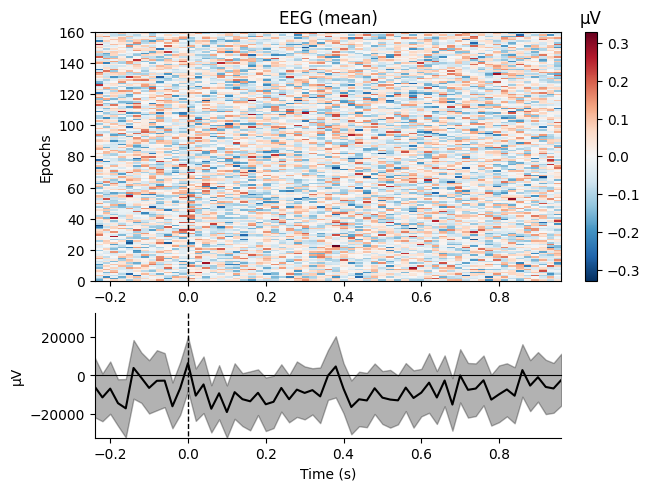

[<Figure size 640x480 with 3 Axes>]

In [6]:
epochs[0].plot_image(picks="eeg", combine="mean", scalings=dict(eeg=1))

## 6. Decoding analysis

### 6.1. Within subject analysis:
We can try to decode each of the labels of interest (face vs. objects and attended vs. unattended) for a given subject and we will see that these effects are present at the expected time points:

Text(0.5, 1.0, 'Sensor space decoding')

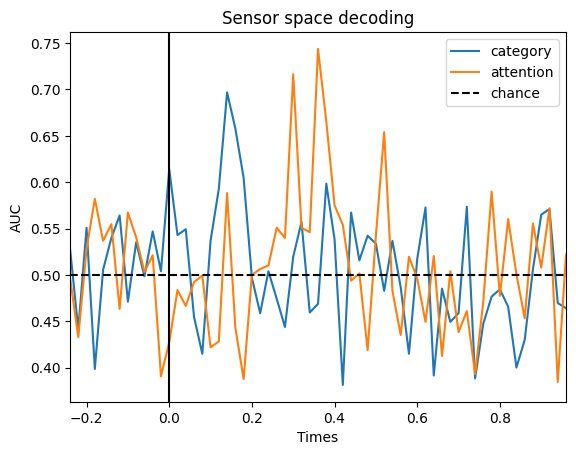

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator, cross_val_multiscore

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Extract the data:
data = epochs[0].get_data()

# Decode faces vs. objects:
cate_lbl = np.array([mapping["category"][val] for val in X[:, 0]])
scores_category = np.mean(
    cross_val_multiscore(
        time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
    ),
    axis=0,
)

# Decode attended vs. unattended:
att_lbl = np.array([mapping["attention"][val] for val in X[:, 1]])
scores_attention = np.mean(
    cross_val_multiscore(
        time_decod, data, att_lbl, cv=5, n_jobs=None, verbose="WARNING"
    ),
    axis=0,
)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs[0].times, scores_category, label="category")
ax.plot(epochs[0].times, scores_attention, label="attention")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

### 6.2. Group level analysis
We simulated the data of 20 subjects, so we can investigate the evidence for decoding of the experimental manipulations at the group level. First, we need to perform the decoding on every single subject:

In [8]:
from mne.stats import permutation_cluster_1samp_test, bootstrap_confidence_interval

scores_category = []
scores_attention = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
            ),
            axis=0,
        )
    )
    # Classification of attention:
    scores_attention.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, att_lbl, cv=5, n_jobs=None, verbose="WARNING"
            ),
            axis=0,
        )
    )

scores_category = np.array(scores_category)
scores_attention = np.array(scores_attention)

We can then apply a cluster based permutation test across subjects to find out when we have an effect:

In [9]:
# Cluster based permutation test for the category:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_category - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_cate = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_cate[clusters[c]] = True

# Cluster based permutation test for the attention:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_attention - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_att = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_att[clusters[c]] = True

Using a threshold of 1.729133
stat_fun(H1): min=-2.23189704749699 max=9.933199426300265
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 1.729133
stat_fun(H1): min=-3.1616701827250253 max=12.427995348632486
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Based on the input to the simulation, we would expect to see a significantly above chance decoding of face vs. object from 0.1 to 0.2 s, and then of attention from 0.3 to 0.4s. Let's check whether that is the case:

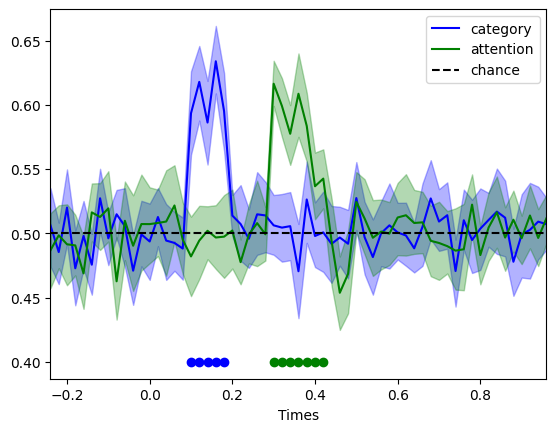

In [10]:
# Compute the confidence intervals:
ci_low_cate, ci_up_cate = bootstrap_confidence_interval(scores_category)
ci_low_att, ci_up_att = bootstrap_confidence_interval(scores_attention)

fig, ax = plt.subplots()
ax.plot(epochs[0].times, np.mean(scores_category, axis=0), label="category", color="b")
ax.fill_between(epochs[0].times, ci_low_cate, ci_up_cate, alpha=0.3, color="b")
ax.plot(
    epochs[0].times[sig_mask_cate],
    np.ones(np.sum(sig_mask_cate)) * 0.4,
    marker="o",
    linestyle="None",
    color="b",
)

ax.plot(
    epochs[0].times, np.mean(scores_attention, axis=0), label="attention", color="g"
)
ax.fill_between(epochs[0].times, ci_low_att, ci_up_att, alpha=0.3, color="g")
ax.plot(
    epochs[0].times[sig_mask_att],
    np.ones(np.sum(sig_mask_att)) * 0.4,
    marker="o",
    linestyle="None",
    color="g",
)
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.legend()
plt.show()

Just as one would expect, we find significant decoding in the expected time windows. This makes designing decoding analysis (or any multivariate techniques such as RSA) very easy, as one can be sure that mistakes crept in, and that the pipeline is sensitive and specific enough